In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import polars as pl
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import gc
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [197]:
gc.collect()

31

In [198]:
df['patient_id'].unique()

patient_id
i64
681
1153
1472
1981
2004
…
8560
8779
8866


In [3]:
probka = pl.read_csv('.\\danonki\\1472_all_confidence.csv', n_rows=50, ignore_errors=True)
kolumny = probka.columns
reference_schema = probka.schema

def cast_to_reference_schema_special(df, reference_schema):
    return df.with_columns([
        # Jeśli docelowy typ to Int64, wykonaj najpierw cast na Float64, a potem na Int64
        pl.col(col_name).cast(pl.Float64).cast(pl.Int64) if reference_schema[col_name] == pl.Int64 
        else pl.col(col_name).cast(reference_schema[col_name])  # Dla pozostałych kolumn wykonaj zwykłe rzutowanie
        for col_name in df.columns if col_name in reference_schema
    ])


folder_path = '.\\danonki'
file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]

# Lista przechowująca przetworzone ramki danych
dane_lazy_frames = []
 
#Przetwarzanie plików
for i, path in enumerate(file_paths):
    print(f"Przetwarzanie pliku {i + 1}/{len(file_paths)}: {path}")

    # Lazy load ramki z rzutowaniem
    dane_lazy = (
        pl.scan_csv(path, ignore_errors=True)
    )

    dane_lazy = cast_to_reference_schema_special(dane_lazy, reference_schema)
 
    dane_lazy_frames.append(dane_lazy)

# Konkatenacja wszystkich ramek danych
dane_combined_lazy = pl.concat(dane_lazy_frames, how="vertical")

# Zmaterializowanie połączonych danych
final_data = dane_combined_lazy.collect()

Przetwarzanie pliku 1/11: .\danonki\1472_all_confidence.csv
Przetwarzanie pliku 2/11: .\danonki\2004_data_confidence.csv
Przetwarzanie pliku 3/11: .\danonki\2500_data_confidence.csv
Przetwarzanie pliku 4/11: .\danonki\2582_all_confidence.csv
Przetwarzanie pliku 5/11: .\danonki\4614_data_confidence.csv
Przetwarzanie pliku 6/11: .\danonki\4953_data_confidence.csv
Przetwarzanie pliku 7/11: .\danonki\5656_data_confidence.csv
Przetwarzanie pliku 8/11: .\danonki\6139_data_confidence.csv
Przetwarzanie pliku 9/11: .\danonki\6241_data_confidence.csv
Przetwarzanie pliku 10/11: .\danonki\6601_data_confidence.csv
Przetwarzanie pliku 11/11: .\danonki\6701_all_confidence.csv


C:\Users\user\AppData\Local\Temp\ipykernel_1780\1905424641.py:10: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  for col_name in df.columns if col_name in reference_schema


In [4]:
probka = pl.read_csv('.\\danonki\\1472_all_confidence.csv', n_rows=50, ignore_errors=True)
kolumny = probka.columns
reference_schema = probka.schema

def cast_to_reference_schema_special(df, reference_schema):
    return df.with_columns([
        # Jeśli docelowy typ to Int64, wykonaj najpierw cast na Float64, a potem na Int64
        pl.col(col_name).cast(pl.Float64).cast(pl.Int64) if reference_schema[col_name] == pl.Int64 
        else pl.col(col_name).cast(reference_schema[col_name])  # Dla pozostałych kolumn wykonaj zwykłe rzutowanie
        for col_name in df.columns if col_name in reference_schema
    ])


folder_path = '.\\danonki2'
file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]

# Lista przechowująca przetworzone ramki danych
dane_lazy_frames = []
 
#Przetwarzanie plików
for i, path in enumerate(file_paths):
    print(f"Przetwarzanie pliku {i + 1}/{len(file_paths)}: {path}")

    # Lazy load ramki z rzutowaniem
    dane_lazy = (
        pl.scan_csv(path, ignore_errors=True)
    )

    dane_lazy = cast_to_reference_schema_special(dane_lazy, reference_schema)
 
    dane_lazy_frames.append(dane_lazy)

# Konkatenacja wszystkich ramek danych
dane_combined_lazy2 = pl.concat(dane_lazy_frames, how="vertical")

# Zmaterializowanie połączonych danych
final_data2 = dane_combined_lazy2.collect()

Przetwarzanie pliku 1/13: .\danonki2\0681_data_confidence.csv
Przetwarzanie pliku 2/13: .\danonki2\1153_data_confidence.csv
Przetwarzanie pliku 3/13: .\danonki2\1981_all_confidence.csv
Przetwarzanie pliku 4/13: .\danonki2\6754_data_confidence.csv
Przetwarzanie pliku 5/13: .\danonki2\7297_data_confidence.csv
Przetwarzanie pliku 6/13: .\danonki2\7379_data_confidence.csv
Przetwarzanie pliku 7/13: .\danonki2\8193_data_confidence.csv
Przetwarzanie pliku 8/13: .\danonki2\8281_data_confidence.csv
Przetwarzanie pliku 9/13: .\danonki2\8560_all_confidence.csv
Przetwarzanie pliku 10/13: .\danonki2\8779_data_confidence.csv
Przetwarzanie pliku 11/13: .\danonki2\8866_data_confidence.csv
Przetwarzanie pliku 12/13: .\danonki2\9813_data_confidence.csv
Przetwarzanie pliku 13/13: .\danonki2\9829_data_confidence.csv


C:\Users\user\AppData\Local\Temp\ipykernel_1780\959448906.py:10: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  for col_name in df.columns if col_name in reference_schema


In [5]:
del dane_combined_lazy, dane_combined_lazy2 , dane_lazy, dane_lazy_frames, file_paths, folder_path, i, kolumny, path, reference_schema

In [6]:
df = pl.concat([final_data, final_data2], how="vertical")

In [7]:
del final_data, final_data2

In [8]:
df = df.fill_null(0)

## Przygotowanie danych

In [125]:
start_idx = df.columns.index('pcm_LOGenergy_sma')
end_idx = df.columns.index('pcm_fftMag_mfcc_12_')
    
# Select specific columns along with the dynamically sliced columns
feature_columns = df.select(df.columns[start_idx:end_idx+1 ]).columns

### Podział zbioru na dni wizyty i dni pozostałe

In [126]:
train = df.filter(pl.col('time_point') != 0)
test = df.filter(pl.col('time_point') == 0)

In [127]:
grouped_train = train.partition_by('mr')
grouped_test = test.partition_by('mr')

In [128]:
train_arrays = []
train_y = []
train_weight = []
max_frames = 1000    # Liczba ramek do przetworzenia

for group in grouped_train:
    # Sort frames
    group_sorted = group.sort('frame_nr')  # or 'chunk_number'
    features = group_sorted.select(feature_columns).to_numpy()

    # Handle variable frame lengths
    num_frames = features.shape[0]
    if num_frames > max_frames:
        # Truncate
        features = features[:max_frames, :]
    elif num_frames < max_frames:
        # Padding with zeros
        padding = np.zeros((max_frames - num_frames, features.shape[1]))
        features = np.vstack((features, padding))

    train_arrays.append(features)
    train_y.append(group_sorted["label"].explode().unique())
    train_weight.append(group_sorted["confidence_linear"].explode().unique())

In [129]:
test_arrays = []
test_y = []
test_weight = []
max_frames = 1000  # Liczba ramek do przetworzenia

for group in grouped_test:
    # Sort frames
    group_sorted = group.sort('frame_nr')  # or 'chunk_number'

    # Extract feature values as a NumPy array
    features = group_sorted.select(feature_columns).to_numpy()

    # Handle variable frame lengths
    num_frames = features.shape[0]
    if num_frames > max_frames:
        # Truncate
        features = features[:max_frames, :]
    elif num_frames < max_frames:
        # Padding with zeros
        padding = np.zeros((max_frames - num_frames, features.shape[1]))
        features = np.vstack((features, padding))

    test_arrays.append(features)
    test_y.append(group_sorted["label"].explode().unique())
    test_weight.append(group_sorted["confidence_linear"].explode().unique())

In [161]:
#  (num_conversations, max_frames, num_features)
X_train = np.stack(train_arrays)
X_test = np.stack(test_arrays)

Y_train = np.stack(train_y)
Y_test = np.stack(test_y)

X_train_weight = np.stack(train_weight)
X_test_weight = np.stack(test_weight)

In [162]:
from sklearn.model_selection import train_test_split

# Ustalmy zmienne
X_train, X_valid, Y_train, Y_valid, train_weights, valid_weights = train_test_split(X_train, Y_train, X_train_weight, test_size=0.25, random_state=42, stratify= Y_train)



In [163]:
label_mapping = {
    'euthymia': 0,
    'depression': 1,
    'mania': 2,
    'mixed': 3
}

vectorized_mapping = np.vectorize(label_mapping.get)
Y_train = vectorized_mapping(Y_train)
Y_test = vectorized_mapping(Y_test)
Y_valid = vectorized_mapping(Y_valid)
Y_train

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [164]:
# Convert integer labels to one-hot encoded vectors
Y_train = to_categorical(Y_train, num_classes=4)
Y_test = to_categorical(Y_test, num_classes=4)
Y_valid = to_categorical(Y_valid, num_classes=4)

In [165]:
scaler = StandardScaler()
#X_train
X_train_scaled_flat = X_train.reshape(-1, X_train.shape[-1])
X_train_scaled_flat =  scaler.fit_transform(X_train_scaled_flat)
X_train_scaled = X_train_scaled_flat.reshape(X_train.shape)

#X_valid
X_valid_scaled_flat = X_valid.reshape(-1, X_valid.shape[-1])
X_valid_scaled_flat =  scaler.fit_transform(X_valid_scaled_flat)
X_valid_scaled = X_valid_scaled_flat.reshape(X_valid.shape)

#X_test
X_test_scaled_flat = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled_flat =  scaler.fit_transform(X_test_scaled_flat)
X_test_scaled = X_test_scaled_flat.reshape(X_test.shape)

#Y_train_flat = Y_train.reshape(-1)
#Y_test_flat = Y_test.reshape(-1)

Y_train_flat = np.repeat(Y_train, X_train.shape[1])  # X_train.shape[1] = 1000
Y_test_flat = np.repeat(Y_test, X_test.shape[1])

In [166]:
num_features = X_train.shape[2]
num_classes = 4
num_features

86

## Simple CNN, LSTM, RNN

In [201]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM, SimpleRNN
)
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
import os
import random
 
 

## Definicja modeli

In [202]:
# 2a. Definiowanie Modelu Conv1D (CNN dla Danych Sekwencyjnych)
def create_conv1d_model(input_shape=(max_frames, num_features), num_classes=num_classes, l2_lambda=0.01):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu',
               kernel_regularizer=regularizers.l2(l2_lambda),
               input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        
        Conv1D(filters=256, kernel_size=3, activation='relu' 
               ,kernel_regularizer=regularizers.l2(l2_lambda)
               ),
        MaxPooling1D(pool_size=2),
        
        Flatten(),
        Dense(128, activation='relu',
              kernel_regularizer=regularizers.l2(l2_lambda)),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'] 
       , weighted_metrics=['accuracy']
    )
    return model

# 2b. Definiowanie Modelu LSTM
def create_lstm_model(input_shape=(max_frames, num_features), num_classes=num_classes, l2_lambda=0.01):
    model = Sequential([
        LSTM(64, return_sequences=True,
             kernel_regularizer=regularizers.l2(l2_lambda),
             recurrent_regularizer=regularizers.l2(l2_lambda),
             input_shape=input_shape),
        Dropout(0.2),
        
        LSTM(64,
             kernel_regularizer=regularizers.l2(l2_lambda),
             recurrent_regularizer=regularizers.l2(l2_lambda)),
        Dropout(0.2),
        
        Dense(64, activation='relu',
              kernel_regularizer=regularizers.l2(l2_lambda)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
        , weighted_metrics=['accuracy']
    )
    return model

# 2c. Definiowanie Modelu RNN
def create_rnn_model(input_shape=(max_frames, num_features), num_classes=num_classes, l2_lambda=0.01):
    model = Sequential([
        SimpleRNN(64, return_sequences=True,
                  kernel_regularizer=regularizers.l2(l2_lambda),
                  recurrent_regularizer=regularizers.l2(l2_lambda),
                  input_shape=input_shape),
        Dropout(0.2),
        
        SimpleRNN(64,
                  kernel_regularizer=regularizers.l2(l2_lambda),
                  recurrent_regularizer=regularizers.l2(l2_lambda)),
        Dropout(0.2),
        
        Dense(64, activation='relu',
              kernel_regularizer=regularizers.l2(l2_lambda)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
        , weighted_metrics=['accuracy']
    )
    return model

 
# 2c. Definiowanie Modelu CNN + LSTM 
def create_cnn_lstm_model(input_shape=(max_frames, num_features), num_classes=num_classes, l2_lambda=0.01):
    model = Sequential([
        # Część CNN
        Conv1D(filters=64, kernel_size=3, activation='relu',
               kernel_regularizer=regularizers.l2(l2_lambda),
               input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        
        Conv1D(filters=128, kernel_size=3, activation='relu',
               kernel_regularizer=regularizers.l2(l2_lambda)),
        MaxPooling1D(pool_size=2),
        
        Dropout(0.3),  # Dodatkowa regularizacja przed LSTM
        
        # Przekształcenie do sekwencji na wejściu do LSTM
        LSTM(64, return_sequences=True, 
             kernel_regularizer=regularizers.l2(l2_lambda),
             recurrent_regularizer=regularizers.l2(l2_lambda)),
        Dropout(0.3),
        
        LSTM(64,
             kernel_regularizer=regularizers.l2(l2_lambda),
             recurrent_regularizer=regularizers.l2(l2_lambda)),
        Dropout(0.5),
        
        # Warstwa końcowa
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
        , weighted_metrics=['accuracy']
    )
    
    return model




In [203]:
# Słownik funkcji budujących modele
model_builders = {
    'cnn': create_conv1d_model ,
    'lstm': create_lstm_model ,
    #'rnn': create_rnn_model ,
    'cnn_lstm' : create_cnn_lstm_model
}

## Trenowanie bez wag

In [209]:
import tensorflow as tf
import numpy as np
import random
import os

# Ustawienie zmiennych środowiskowych dla deterministycznych operacji
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Ustawienie seedów
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

from tensorflow.keras import models, layers, initializers

 




# Tworzenie modelu Conv1D
# conv1d_model = create_conv1d_model()
# print("\nModel Conv1D (CNN dla danych sekwencyjnych):")

# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# print("\nTrenowanie modelu Conv1D (CNN dla danych sekwencyjnych) z wagami!!! ")
 

# history_conv1d = conv1d_model.fit(
#     X_train_scaled, Y_train ,
#     epochs=20,
#     batch_size=32,
#     validation_data=(X_valid_scaled, Y_valid, valid_weights),
#     callbacks=[early_stopping],
#     sample_weight = train_weights,
#     verbose=1
# )

# plot_history(history_conv1d, 'Conv1D Model')

##########################################################
# Słownik funkcji budujących modele

##########################################################
# BEZ WAG
##########################################################

histories_no_weights = {}
trained_models_no_weights = {}


for model_name, build_function in model_builders.items():
    print(f'Training {model_name}...')
    tf.random.set_seed(42)
    model = build_function()
    history = model.fit(
    X_train_scaled, Y_train ,
    epochs=10,
    batch_size=32,
    validation_data=(X_valid_scaled, Y_valid ), #, valid_weights),
    callbacks=[early_stopping],
    #sample_weight = train_weights,
    verbose=1
    )
    histories_no_weights[model_name] = history
    trained_models_no_weights[model_name] = model  # Zapisujemy wytrenowany model
    print(f'{model_name} training completed.')

def plot_metric(histories, metric):
    plt.figure(figsize=(12, 6))
    
    for model_name, history in histories.items():
        plt.plot(history.history[metric], label=f'{model_name} - train')
        plt.plot(history.history[f'val_{metric}'], linestyle='--', label=f'{model_name} - val')
    
    plt.title(f'Porównanie {metric}')
    plt.xlabel('Epoka')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metric(histories_no_weights, 'accuracy')
plot_metric(histories_no_weights, 'loss')

Training cnn...
Epoch 1/10
65/65 [==============================] - 9s 134ms/step - loss: 5.4345 - accuracy: 0.4524 - weighted_accuracy: 0.4524 - val_loss: 3.4764 - val_accuracy: 0.5412 - val_weighted_accuracy: 0.5412
Epoch 2/10
65/65 [==============================] - 8s 121ms/step - loss: 2.8638 - accuracy: 0.6369 - weighted_accuracy: 0.6369 - val_loss: 2.6213 - val_accuracy: 0.5847 - val_weighted_accuracy: 0.5847
Epoch 3/10
65/65 [==============================] - 8s 122ms/step - loss: 2.1953 - accuracy: 0.6895 - weighted_accuracy: 0.6895 - val_loss: 2.2295 - val_accuracy: 0.6165 - val_weighted_accuracy: 0.6165
Epoch 4/10
65/65 [==============================] - 8s 117ms/step - loss: 1.9055 - accuracy: 0.7219 - weighted_accuracy: 0.7219 - val_loss: 2.0249 - val_accuracy: 0.5818 - val_weighted_accuracy: 0.5818
Epoch 5/10
65/65 [==============================] - 8s 116ms/step - loss: 1.6169 - accuracy: 0.7566 - weighted_accuracy: 0.7566 - val_loss: 1.8452 - val_accuracy: 0.6498 - val_

KeyboardInterrupt: 

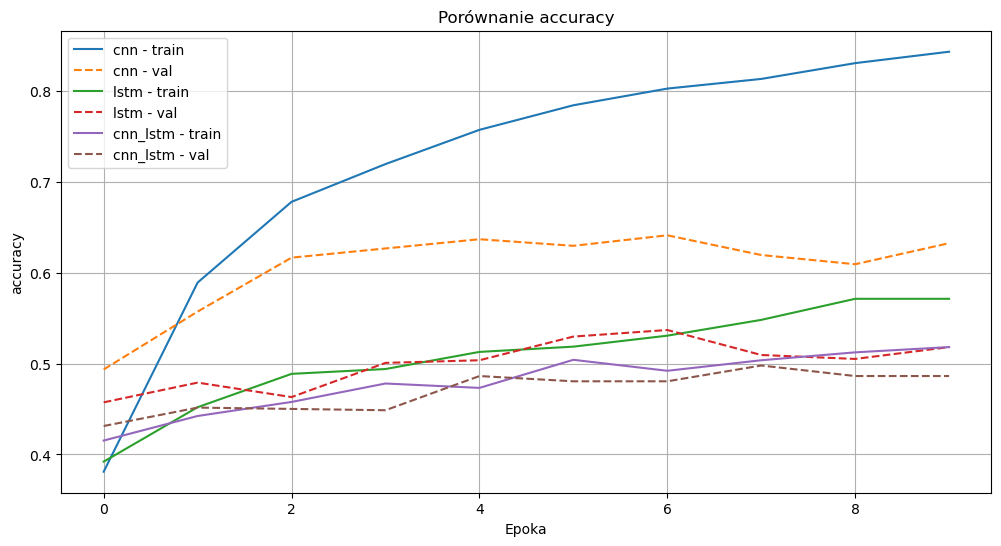

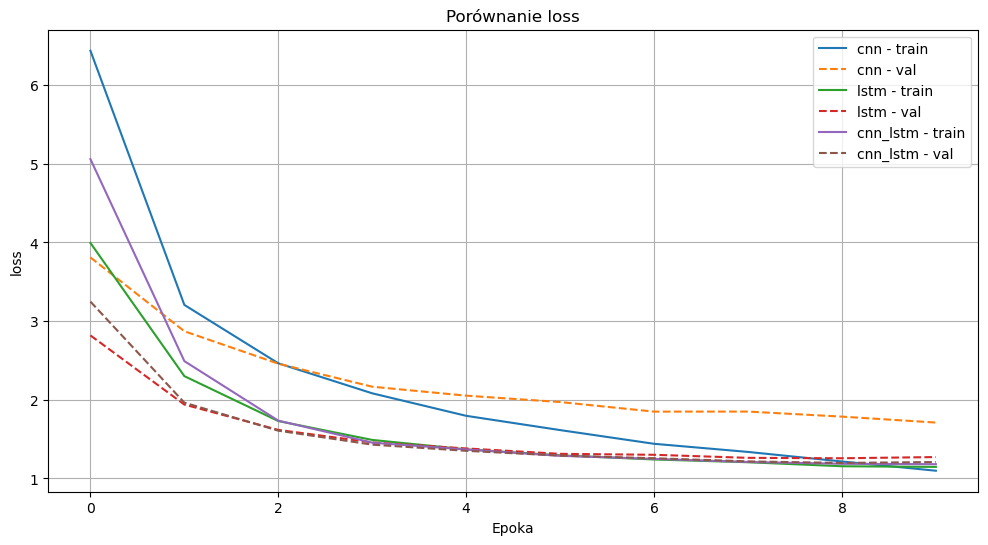

In [194]:
plot_metric(histories_no_weights, 'accuracy')
plot_metric(histories_no_weights, 'loss')

In [195]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import numpy as np


metrics_list = []
 


for model_name, model in trained_models_no_weights.items():
    print(f'Evaluating {model_name}...')
    # Ocena modelu na zbiorze testowym
    loss, accuracy, weighted_accuracy  = model.evaluate(X_test_scaled, Y_test )
    
    # Przewidywania na zbiorze testowym
    y_pred_probs = model.predict(X_test_scaled)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(Y_test, axis=1)
    
    # Obliczanie precyzji, recall, F1-score
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    
    # Dodanie metryk do listy
    metrics_list.append({
        'Model': model_name,
        'Accuracy': round(accuracy, 4),
        'Loss': round(loss, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-score': round(f1, 4)
    })

# Tworzenie DataFrame z metrykami
metrics_df = pd.DataFrame(metrics_list)
metrics_df.set_index('Model', inplace=True)

# Wyświetlenie tabeli
print(metrics_df)

Evaluating cnn...
12/12 [==============================] - 1s 39ms/step
Evaluating lstm...
12/12 [==============================] - 7s 466ms/step
Evaluating cnn_lstm...
12/12 [==============================] - 3s 136ms/step
          Accuracy    Loss  Precision  Recall  F1-score
Model                                                  
cnn         0.5692  1.9178     0.5869  0.5692    0.5693
lstm        0.5039  1.2709     0.5479  0.5039    0.5054
cnn_lstm    0.4360  1.2464     0.2994  0.4360    0.3531


c:\Users\user\anaconda3\envs\phd\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [205]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

from sklearn.metrics import roc_auc_score
import numpy as np


In [207]:
for model_name, model in trained_models_no_weights.items():
    print(f'Evaluating {model_name}...')

Evaluating cnn...


In [208]:
trained_models_no_weights.items()

dict_items([('cnn', <keras.engine.sequential.Sequential object at 0x00000205E9F88130>)])

In [ ]:
 


for model_name, model in trained_models_no_weights.items():
    print(f'Evaluating {model_name}...')
    # Ocena modelu na zbiorze testowym
    #loss, accuracy, weighted_accuracy  = model.evaluate(X_test_scaled, Y_test )
    
    # Przewidywania na zbiorze testowym
    y_pred_probs = model.predict(X_test_scaled)

    roc_auc = roc_auc_score(Y_test, y_pred_probs, average='macro', multi_class='ovr')           

    print(f"Model {model_name} having AUC-ROC (macro average): {roc_auc:.4f}")

    # Zakładając, że masz dane testowe i model wytrenowany
    num_classes = num_classes  # liczba klas
     

    # Konwersja prawdziwych etykiet do formatu one-hot, jeśli jeszcze nie są
    y_true_onehot = Y_test

    # Inicjalizacja wykresu
    plt.figure(figsize=(10, 8))

    # Obliczenie krzywych ROC dla każdej klasy
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Klasa {i} (AUC = {roc_auc:.2f})")

    # Dodanie przekątnej dla klasyfikacji losowej
    plt.plot([0, 1], [0, 1], 'k--', label='Losowa klasyfikacja (AUC = 0.50)')

    # Dostosowanie wykresu
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("Wykres ROC AUC dla każdej klasy")
    plt.legend(loc="lower right")
    plt.grid()

    # Wyświetlenie wykresu
    plt.show()





## Trenowanie z wagami

Training cnn...
Epoch 1/10
65/65 [==============================] - 9s 132ms/step - loss: 4.1648 - accuracy: 0.3085 - weighted_accuracy: 0.3380 - val_loss: 2.4776 - val_accuracy: 0.3560 - val_weighted_accuracy: 0.4608
Epoch 2/10
65/65 [==============================] - 8s 119ms/step - loss: 2.0143 - accuracy: 0.4389 - weighted_accuracy: 0.5194 - val_loss: 1.7177 - val_accuracy: 0.4457 - val_weighted_accuracy: 0.5099
Epoch 3/10
65/65 [==============================] - 7s 115ms/step - loss: 1.4476 - accuracy: 0.5282 - weighted_accuracy: 0.6170 - val_loss: 1.3468 - val_accuracy: 0.4790 - val_weighted_accuracy: 0.5623
Epoch 4/10
65/65 [==============================] - 8s 118ms/step - loss: 1.1357 - accuracy: 0.5451 - weighted_accuracy: 0.6598 - val_loss: 1.0931 - val_accuracy: 0.5051 - val_weighted_accuracy: 0.5790
Epoch 5/10
65/65 [==============================] - 7s 115ms/step - loss: 0.9497 - accuracy: 0.5703 - weighted_accuracy: 0.6784 - val_loss: 0.9639 - val_accuracy: 0.4674 - val_

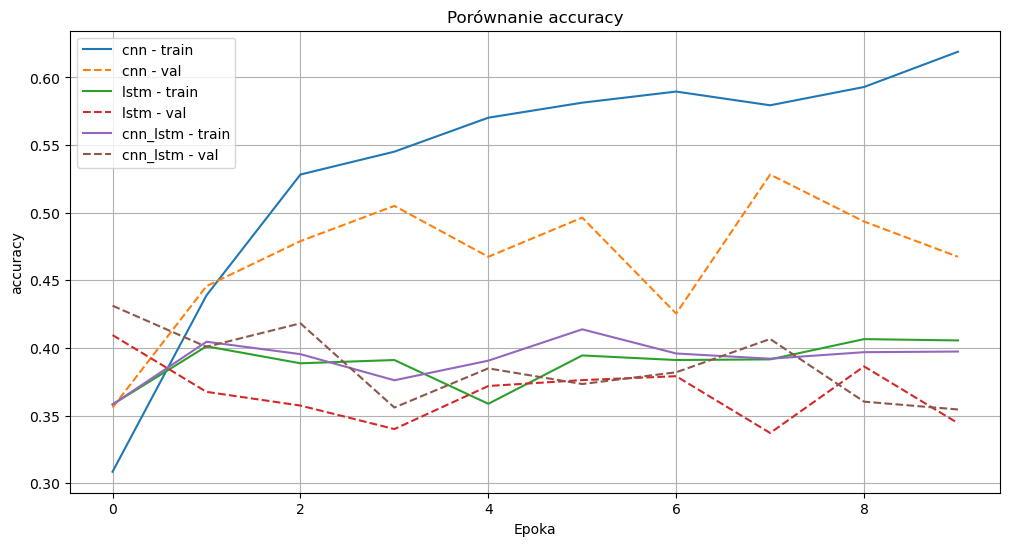

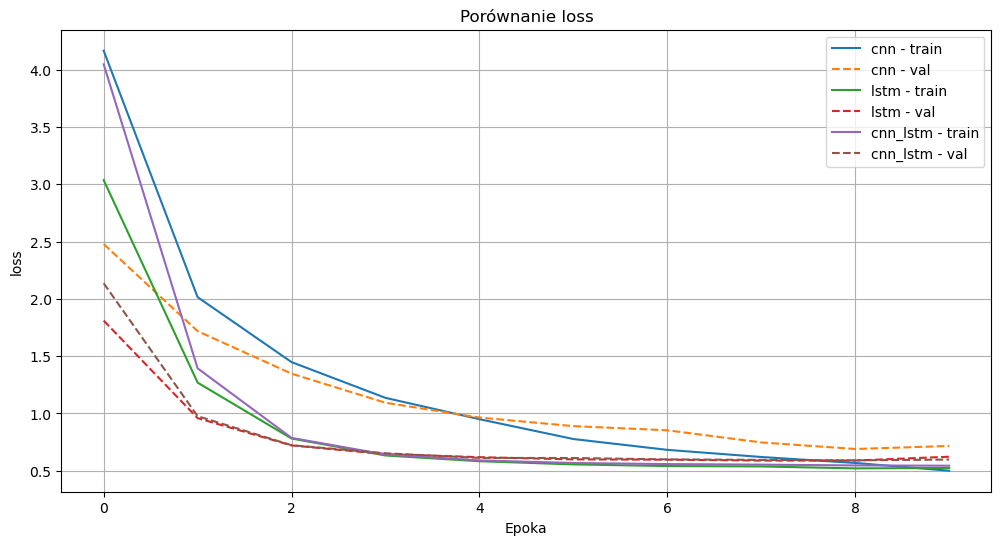

In [187]:
import tensorflow as tf
import numpy as np
import random
import os

# Ustawienie zmiennych środowiskowych dla deterministycznych operacji
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Ustawienie seedów
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

from tensorflow.keras import models, layers, initializers

 


histories = {}
trained_models = {}


for model_name, build_function in model_builders.items():
    print(f'Training {model_name}...')
    tf.random.set_seed(42)
    model = build_function()
    history = model.fit(
    X_train_scaled, Y_train ,
    epochs=10,
    batch_size=32,
    validation_data=(X_valid_scaled, Y_valid , valid_weights),
    callbacks=[early_stopping],
    sample_weight = train_weights,
    verbose=1
    )
    histories[model_name] = history
    trained_models[model_name] = model  # Zapisujemy wytrenowany model
    print(f'{model_name} training completed.')

def plot_metric(histories, metric):
    plt.figure(figsize=(12, 6))
    
    for model_name, history in histories.items():
        plt.plot(history.history[metric], label=f'{model_name} - train')
        plt.plot(history.history[f'val_{metric}'], linestyle='--', label=f'{model_name} - val')
    
    plt.title(f'Porównanie {metric}')
    plt.xlabel('Epoka')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metric(histories, 'accuracy')
plot_metric(histories, 'loss')


Trenowanie modelu Conv1D (CNN dla danych sekwencyjnych)...
Epoch 1/20
70/70 [==============================] - 11s 141ms/step - loss: 5.4090 - accuracy: 0.4459 - val_loss: 3.3928 - val_accuracy: 0.5425
Epoch 2/20
70/70 [==============================] - 10s 136ms/step - loss: 2.8232 - accuracy: 0.6016 - val_loss: 2.4319 - val_accuracy: 0.6311
Epoch 3/20
70/70 [==============================] - 9s 126ms/step - loss: 2.1286 - accuracy: 0.6822 - val_loss: 2.1259 - val_accuracy: 0.5805
Epoch 4/20
70/70 [==============================] - 9s 128ms/step - loss: 1.9424 - accuracy: 0.6618 - val_loss: 1.8422 - val_accuracy: 0.6492
Epoch 5/20
70/70 [==============================] - 9s 123ms/step - loss: 1.5610 - accuracy: 0.7402 - val_loss: 1.7132 - val_accuracy: 0.6401
Epoch 6/20
70/70 [==============================] - 9s 122ms/step - loss: 1.5063 - accuracy: 0.7365 - val_loss: 1.7289 - val_accuracy: 0.6365
Epoch 7/20
70/70 [==============================] - 9s 123ms/step - loss: 1.3287 - acc

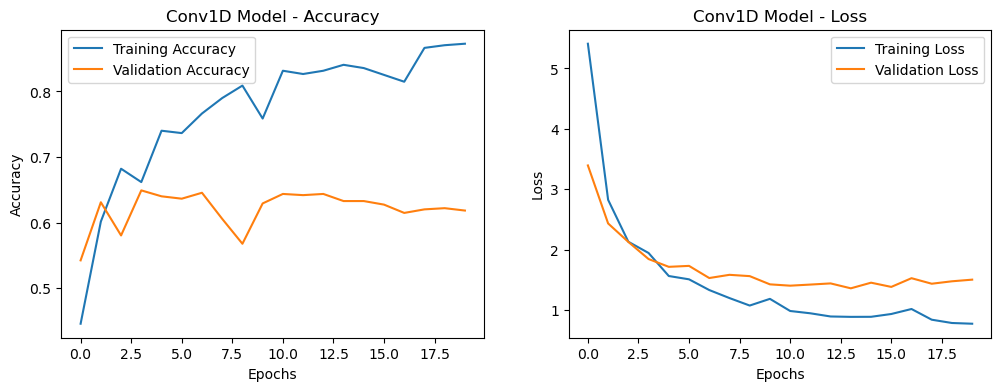

In [117]:
print("\nTrenowanie modelu Conv1D (CNN dla danych sekwencyjnych)...")
import keras
keras.utils.set_random_seed(812)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
tf.config.experimental.enable_op_determinism()

tf.random.set_seed(42)
history_conv1d = conv1d_model.fit(
    X_train_scaled, Y_train ,
    epochs=10,
    batch_size=32,
    validation_data=(X_valid_scaled, Y_valid),
    callbacks=[early_stopping],
    verbose=1
)
plot_history(history_conv1d, 'Conv1D Model')

In [191]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import numpy as np


metrics_list = []
 


for model_name, model in trained_models.items():
    print(f'Evaluating {model_name}...')
    # Ocena modelu na zbiorze testowym
    loss, accuracy, weighted_accuracy  = model.evaluate(X_test_scaled, Y_test )
    
    # Przewidywania na zbiorze testowym
    y_pred_probs = model.predict(X_test_scaled)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(Y_test, axis=1)
    
    # Obliczanie precyzji, recall, F1-score
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    
    # Dodanie metryk do listy
    metrics_list.append({
        'Model': model_name,
        'Accuracy': round(accuracy, 4),
        'Loss': round(loss, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-score': round(f1, 4)
    })

# Tworzenie DataFrame z metrykami
metrics_df = pd.DataFrame(metrics_list)
metrics_df.set_index('Model', inplace=True)

# Wyświetlenie tabeli
print(metrics_df)

Evaluating cnn...
12/12 [==============================] - 0s 23ms/step
Evaluating lstm...
12/12 [==============================] - 5s 326ms/step
Evaluating cnn_lstm...


c:\Users\user\anaconda3\envs\phd\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


12/12 [==============================] - 2s 92ms/step
          Accuracy    Loss  Precision  Recall  F1-score
Model                                                  
cnn         0.4517  1.8715     0.4690  0.4517    0.4250
lstm        0.3133  1.3436     0.3230  0.3133    0.2728
cnn_lstm    0.3368  1.2345     0.3287  0.3368    0.2982


c:\Users\user\anaconda3\envs\phd\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:


# Tworzenie modelu LSTM
lstm_model = create_lstm_model()
print("\nModel LSTM:")
lstm_model.summary()



# Tworzenie modelu RNN
rnn_model = create_rnn_model()
print("\nModel RNN:")
rnn_model.summary()

In [28]:

# 3b. Trenowanie Modelu LSTM
print("\nTrenowanie modelu LSTM...")
history_lstm = lstm_model.fit(
    X_train_scaled, Y_train ,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_scaled, Y_test),
    verbose=1
)



Trenowanie modelu LSTM...
Epoch 1/10
87/87 [==============================] - 201s 2s/step - loss: 1.2410 - accuracy: 0.4182 - val_loss: 1.1066 - val_accuracy: 0.4909
Epoch 2/10
87/87 [==============================] - 198s 2s/step - loss: 1.1257 - accuracy: 0.4750 - val_loss: 1.0844 - val_accuracy: 0.5196
Epoch 3/10
87/87 [==============================] - 203s 2s/step - loss: 1.0644 - accuracy: 0.5261 - val_loss: 1.0983 - val_accuracy: 0.5170
Epoch 4/10
87/87 [==============================] - 207s 2s/step - loss: 1.0156 - accuracy: 0.5641 - val_loss: 1.0800 - val_accuracy: 0.5196
Epoch 5/10
87/87 [==============================] - 208s 2s/step - loss: 0.9914 - accuracy: 0.5807 - val_loss: 1.1010 - val_accuracy: 0.5013
Epoch 6/10
87/87 [==============================] - 206s 2s/step - loss: 0.9474 - accuracy: 0.5952 - val_loss: 1.1188 - val_accuracy: 0.5326
Epoch 7/10
87/87 [==============================] - 206s 2s/step - loss: 0.9188 - accuracy: 0.6206 - val_loss: 1.1089 - val_acc

In [29]:
# 3c. Trenowanie Modelu RNN
print("\nTrenowanie modelu RNN...")
history_rnn = rnn_model.fit(
    X_train_scaled, Y_train ,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_scaled, Y_test),
    verbose=1
)




Trenowanie modelu RNN...
Epoch 1/10
87/87 [==============================] - 121s 1s/step - loss: 1.3629 - accuracy: 0.3570 - val_loss: 1.1643 - val_accuracy: 0.4595
Epoch 2/10
87/87 [==============================] - 121s 1s/step - loss: 1.2364 - accuracy: 0.4131 - val_loss: 1.1208 - val_accuracy: 0.5013
Epoch 3/10
87/87 [==============================] - 121s 1s/step - loss: 1.1852 - accuracy: 0.4493 - val_loss: 1.1188 - val_accuracy: 0.4752
Epoch 4/10
87/87 [==============================] - 122s 1s/step - loss: 1.1507 - accuracy: 0.4623 - val_loss: 1.0937 - val_accuracy: 0.4752
Epoch 5/10
87/87 [==============================] - 124s 1s/step - loss: 1.1341 - accuracy: 0.4616 - val_loss: 1.1195 - val_accuracy: 0.4830
Epoch 6/10
87/87 [==============================] - 120s 1s/step - loss: 1.1173 - accuracy: 0.4783 - val_loss: 1.1454 - val_accuracy: 0.4413
Epoch 7/10
87/87 [==============================] - 117s 1s/step - loss: 1.0974 - accuracy: 0.5029 - val_loss: 1.1002 - val_accu

In [78]:
# 4. Ewaluacja Modeli
print("\nEwaluacja modelu Conv1D  :")
loss_conv1d, acc_conv1d = conv1d_model.evaluate(X_test_scaled, Y_test, verbose=0)
print(f"Dokładność Conv1D: {acc_conv1d*100:.2f}%")

# print("\nEwaluacja modelu LSTM:")
# loss_lstm, acc_lstm = lstm_model.evaluate(X_test_scaled, Y_test, verbose=0)
# print(f"Dokładność LSTM: {acc_lstm*100:.2f}%")

# print("\nEwaluacja modelu RNN:")
# loss_rnn, acc_rnn = rnn_model.evaluate(X_test_scaled, Y_test, verbose=0)
# print(f"Dokładność RNN: {acc_rnn*100:.2f}%")


Ewaluacja modelu Conv1D (CNN dla danych sekwencyjnych):
Dokładność Conv1D: 64.75%


In [85]:
# from tensorflow.keras.utils import plot_model

# plot_model(conv1d_model, to_file='conv1d_model.png', show_shapes=True, show_layer_names=True)

In [200]:
#plot_model(conv1d_model, to_file='conv1d_model.png', show_shapes=True, show_layer_names=True)

In [82]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()



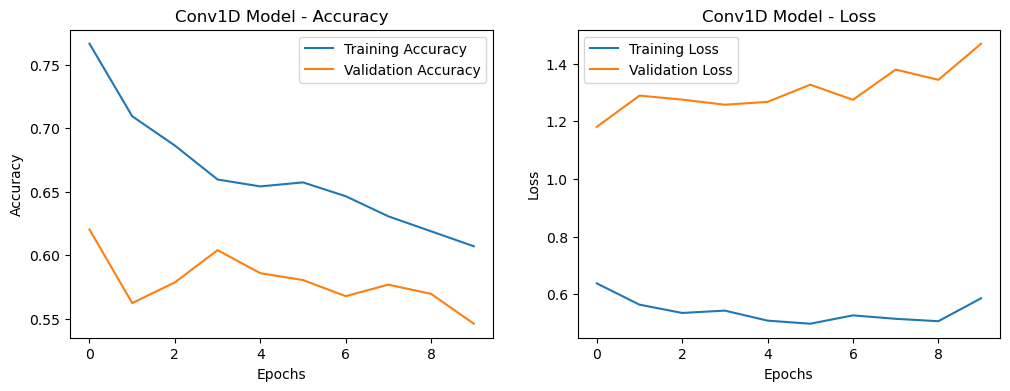

In [90]:
# Plot dla Conv1D
plot_history(history_conv1d, 'Conv1D Model')

# # Plot dla LSTM
# plot_history(history_lstm, 'LSTM Model')

# # Plot dla RNN
# plot_history(history_rnn, 'RNN Model')

In [91]:
from sklearn.metrics import roc_auc_score
import numpy as np
# 1. Wygenerowanie przewidywanych prawdopodobieństw
y_pred_proba = conv1d_model.predict(X_test_scaled)  # Rozmiar: (liczba_próbek, liczba_klas)

# 2. Przekształcenie prawdziwych etykiet do formatu "one-hot"
# Jeśli test_labels są w formacie "one-hot encoded" (np. używając Keras' to_categorical), 
# to możemy bezpośrednio użyć test_labels. Jeśli nie, przekształćmy je:
# from tensorflow.keras.utils import to_categorical
# y_true_onehot = to_categorical(test_labels, num_classes=num_classes)

# 3. Obliczenie AUC-ROC dla każdej klasy
# "average='macro'" oblicza średnią AUC-ROC dla wszystkich klas
roc_auc = roc_auc_score(Y_test, y_pred_proba, average='macro', multi_class='ovr')

print(f"AUC-ROC (macro average): {roc_auc:.4f}")

12/12 [==============================] - 0s 25ms/step
AUC-ROC (macro average): 0.6935


12/12 [==============================] - 0s 26ms/step


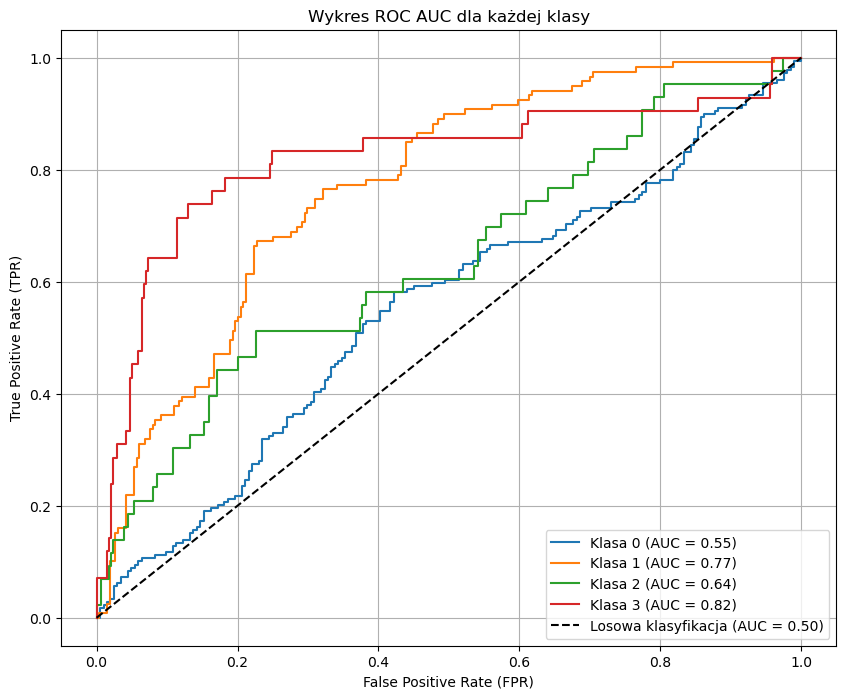

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

from sklearn.metrics import roc_auc_score
import numpy as np
# 1. Wygenerowanie przewidywanych prawdopodobieństw
y_pred_proba = conv1d_model.predict(X_test_scaled)  # Rozmiar: (liczba_próbek, liczba_klas)
 
roc_auc = roc_auc_score(Y_test, y_pred_proba, average='macro', multi_class='ovr')

print(f"AUC-ROC (macro average): {roc_auc:.4f}")


# Zakładając, że masz dane testowe i model wytrenowany
num_classes = num_classes  # liczba klas
y_pred_proba = conv1d_model.predict(X_test_scaled)  # Przewidywane prawdopodobieństwa (np. [num_samples, num_classes])

# Konwersja prawdziwych etykiet do formatu one-hot, jeśli jeszcze nie są
y_true_onehot = Y_test

# Inicjalizacja wykresu
plt.figure(figsize=(10, 8))

# Obliczenie krzywych ROC dla każdej klasy
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Klasa {i} (AUC = {roc_auc:.2f})")

# Dodanie przekątnej dla klasyfikacji losowej
plt.plot([0, 1], [0, 1], 'k--', label='Losowa klasyfikacja (AUC = 0.50)')

# Dostosowanie wykresu
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Wykres ROC AUC dla każdej klasy")
plt.legend(loc="lower right")
plt.grid()

# Wyświetlenie wykresu
plt.show()

In [86]:
test_loss, test_accuracy = conv1d_model.evaluate(X_test_scaled, Y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

12/12 [==============================] - 0s 36ms/step - loss: 1.4356 - accuracy: 0.6475
Test Loss: 1.4355618953704834
Test Accuracy: 0.647519588470459


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def create_optimized_conv1d_model(input_shape=(max_frames, num_features), num_classes=num_classes, l2_lambda=0.01):
    model = Sequential([
                Conv1D(filters=128, kernel_size=3, activation='relu', 
               kernel_regularizer=regularizers.l2(l2_lambda),
               input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        Conv1D(filters=256, kernel_size=3, activation='relu', 
               kernel_regularizer=regularizers.l2(l2_lambda)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.4),

        Conv1D(filters=256, kernel_size=3, activation='relu', 
               kernel_regularizer=regularizers.l2(l2_lambda)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.4),
        
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model




# def create_improved_conv1d_model(input_shape=(max_frames, num_features), num_classes=num_classes, l2_lambda=0.02):
#     model = Sequential([
#         Conv1D(filters=128, kernel_size=3, activation='relu',
#                kernel_regularizer=regularizers.l2(l2_lambda),
#                input_shape=input_shape),
#         BatchNormalization(),
#         MaxPooling1D(pool_size=2),
        
#         Conv1D(filters=256, kernel_size=3, activation='relu',
#                kernel_regularizer=regularizers.l2(l2_lambda)),
#         BatchNormalization(),
#         MaxPooling1D(pool_size=2),
        
#         Dropout(0.4),
        
#         Flatten(),
#         Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)),
#         Dropout(0.4),
#         Dense(num_classes, activation='softmax')
#     ])
    
#     model.compile(
#         optimizer='adam',
#         loss='categorical_crossentropy',
#         metrics=['accuracy']
#     )
#     return model


print("\nTrenowanie modelu Conv1D (CNN dla danych sekwencyjnych)...")


# Tworzenie modelu RNN
improved_conv1d_model = create_optimized_conv1d_model()
 
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model with callbacks
history_conv1d_improved = improved_conv1d_model.fit(
    X_train_scaled, Y_train ,
    batch_size=32,
    validation_data=(X_test_scaled, Y_test),
    verbose=1,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

# history_conv1d_improved = improved_conv1d_model.fit(
#     X_train_scaled, Y_train ,
#     epochs=10,
#     batch_size=32,
#     validation_data=(X_test_scaled, Y_test),
#     callbacks=[early_stopping],
#     verbose=1
# )

# Plot dla Conv1D
plot_history(history_conv1d_improved, 'Conv1D Model')


Trenowanie modelu Conv1D (CNN dla danych sekwencyjnych)...
Epoch 1/30
23/87 [======>.......................] - ETA: 47s - loss: 13.2222 - accuracy: 0.3519

Epoch 1/10
87/87 [==============================] - 10s 106ms/step - loss: 1.5813 - accuracy: 0.4193 - val_loss: 1.1370 - val_accuracy: 0.4935
Epoch 2/10
87/87 [==============================] - 7s 85ms/step - loss: 1.0998 - accuracy: 0.5141 - val_loss: 0.9614 - val_accuracy: 0.6214
Epoch 3/10
87/87 [==============================] - 8s 96ms/step - loss: 0.9291 - accuracy: 0.5967 - val_loss: 0.9316 - val_accuracy: 0.5796
Epoch 4/10
87/87 [==============================] - 9s 99ms/step - loss: 0.8000 - accuracy: 0.6535 - val_loss: 0.9244 - val_accuracy: 0.6449
Epoch 5/10
87/87 [==============================] - 6s 74ms/step - loss: 0.7003 - accuracy: 0.7031 - val_loss: 0.9685 - val_accuracy: 0.6475
Epoch 6/10
87/87 [==============================] - 8s 94ms/step - loss: 0.5978 - accuracy: 0.7343 - val_loss: 0.9872 - val_accuracy: 0.6423
Epoch 7/10
87/87 [==============================] - 7s 82ms/step - loss: 0.5118 - accuracy: 0.7875 - val_loss: 0.9675 - val_accuracy: 0.6319
Epoch 8/10


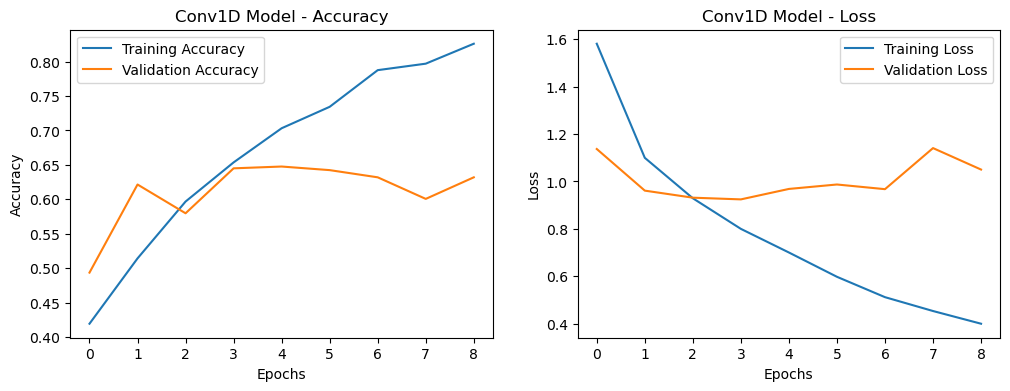

In [65]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

def build_basic_cnn():
    model = models.Sequential([
        # Warstwa konwolucyjna 1
        layers.Conv1D(filters=32, kernel_size=3, activation='relu', 
                      input_shape=(max_frames, num_features)),
        layers.MaxPooling1D(pool_size=2),

        # Warstwa konwolucyjna 2
        layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),

        # Spłaszczenie i warstwy gęste
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),

        # Warstwa wyjściowa
        layers.Dense(num_classes, activation='softmax')
    ])

    # Kompilacja modelu
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


model = build_basic_cnn()
history_cnn1 = model.fit(
    X_train_scaled, Y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_scaled, Y_test),
    callbacks=[early_stopping],
    verbose=1  # Ustaw na 1, jeśli chcesz zobaczyć postęp treningu
)
 
plot_history(history_cnn1, 'Conv1D Model')


# PLENARY & ANN

## bez wag

In [ ]:
# 2d. Definiowanie Modelu ANN - wymaga spłaszczonych danych
def create_ann_model(input_shape=(2000 * 86,), num_classes=4):
    model = Sequential([
        Dense(512, activation='relu', input_shape=input_shape),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Przekształcenie danych dla ANN
X_train_ann = X_train.reshape(X_train.shape[0], -1)
X_val_ann = X_val.reshape(X_val.shape[0], -1)

print(f"\nX_train_ann shape: {X_train_ann.shape}")
print(f"X_val_ann shape: {X_val_ann.shape}")

# Tworzenie modelu ANN
ann_model = create_ann_model()
print("\nModel ANN:")
ann_model.summary()

In [ ]:
# Słownik funkcji budujących modele
model_builders_flat = {
    'ann': create_ann_model 
 
}

In [ ]:
import tensorflow as tf
import numpy as np
import random
import os

# Ustawienie zmiennych środowiskowych dla deterministycznych operacji
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Ustawienie seedów
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

from tensorflow.keras import models, layers, initializers

 


histories = {}
trained_models = {}


for model_name, build_function in model_builders_flat.items():
    print(f'Training {model_name}...')
    tf.random.set_seed(42)
    model = build_function()
    history = model.fit(
    X_train_scaled, Y_train ,
    epochs=10,
    batch_size=32,
    validation_data=(X_valid_scaled, Y_valid , valid_weights),
    callbacks=[early_stopping],
    sample_weight = train_weights,
    verbose=1
    )
    histories[model_name] = history
    trained_models[model_name] = model  # Zapisujemy wytrenowany model
    print(f'{model_name} training completed.')

def plot_metric(histories, metric):
    plt.figure(figsize=(12, 6))
    
    for model_name, history in histories.items():
        plt.plot(history.history[metric], label=f'{model_name} - train')
        plt.plot(history.history[f'val_{metric}'], linestyle='--', label=f'{model_name} - val')
    
    plt.title(f'Porównanie {metric}')
    plt.xlabel('Epoka')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metric(histories, 'accuracy')
plot_metric(histories, 'loss')

## z wagami